## CLIM680 Final Project

_Alison Lawyer, December 2025_

### Global air temperature: influences and impacts

How is air temperature influenced by large climate patterns (i.e., ENSO), and how does it influence regional climate zones?

I'm using Daily max t2m (temperature at 2 meters) over 30 years: 1985-2014 from [ERA5](https://cds.climate.copernicus.eu/datasets/derived-era5-single-levels-daily-statistics?tab=overview).

In [3]:
import os
import calendar

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regionmask

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from scipy.stats import ttest_ind, linregress

## Climatology

What does the data look like? A multi-panel plot of monthly averages over the 30 years of data gives us a good idea.

In [4]:
# load in dataset with monthly t2m means across the globe from 1985-2014
t2m_means = xr.open_dataset('/home/alawyer2/era5-data/all-monthly-means.nc')

# load in original data to compare with means
years = range(1985, 2015) 
directory_path = '/projects/lortizur/cop_climate/era5/'
files_list = [directory_path+f for f in os.listdir(directory_path) if int(f[-10:-6]) in years]
ds = xr.open_mfdataset(files_list)

# convert K to ºC
ds['t2m'] = (ds['t2m'] - 273.15).assign_attrs(units='degC')

Text(0.5, 0.95, 'Average monthly temperature (ºC at 2m)')

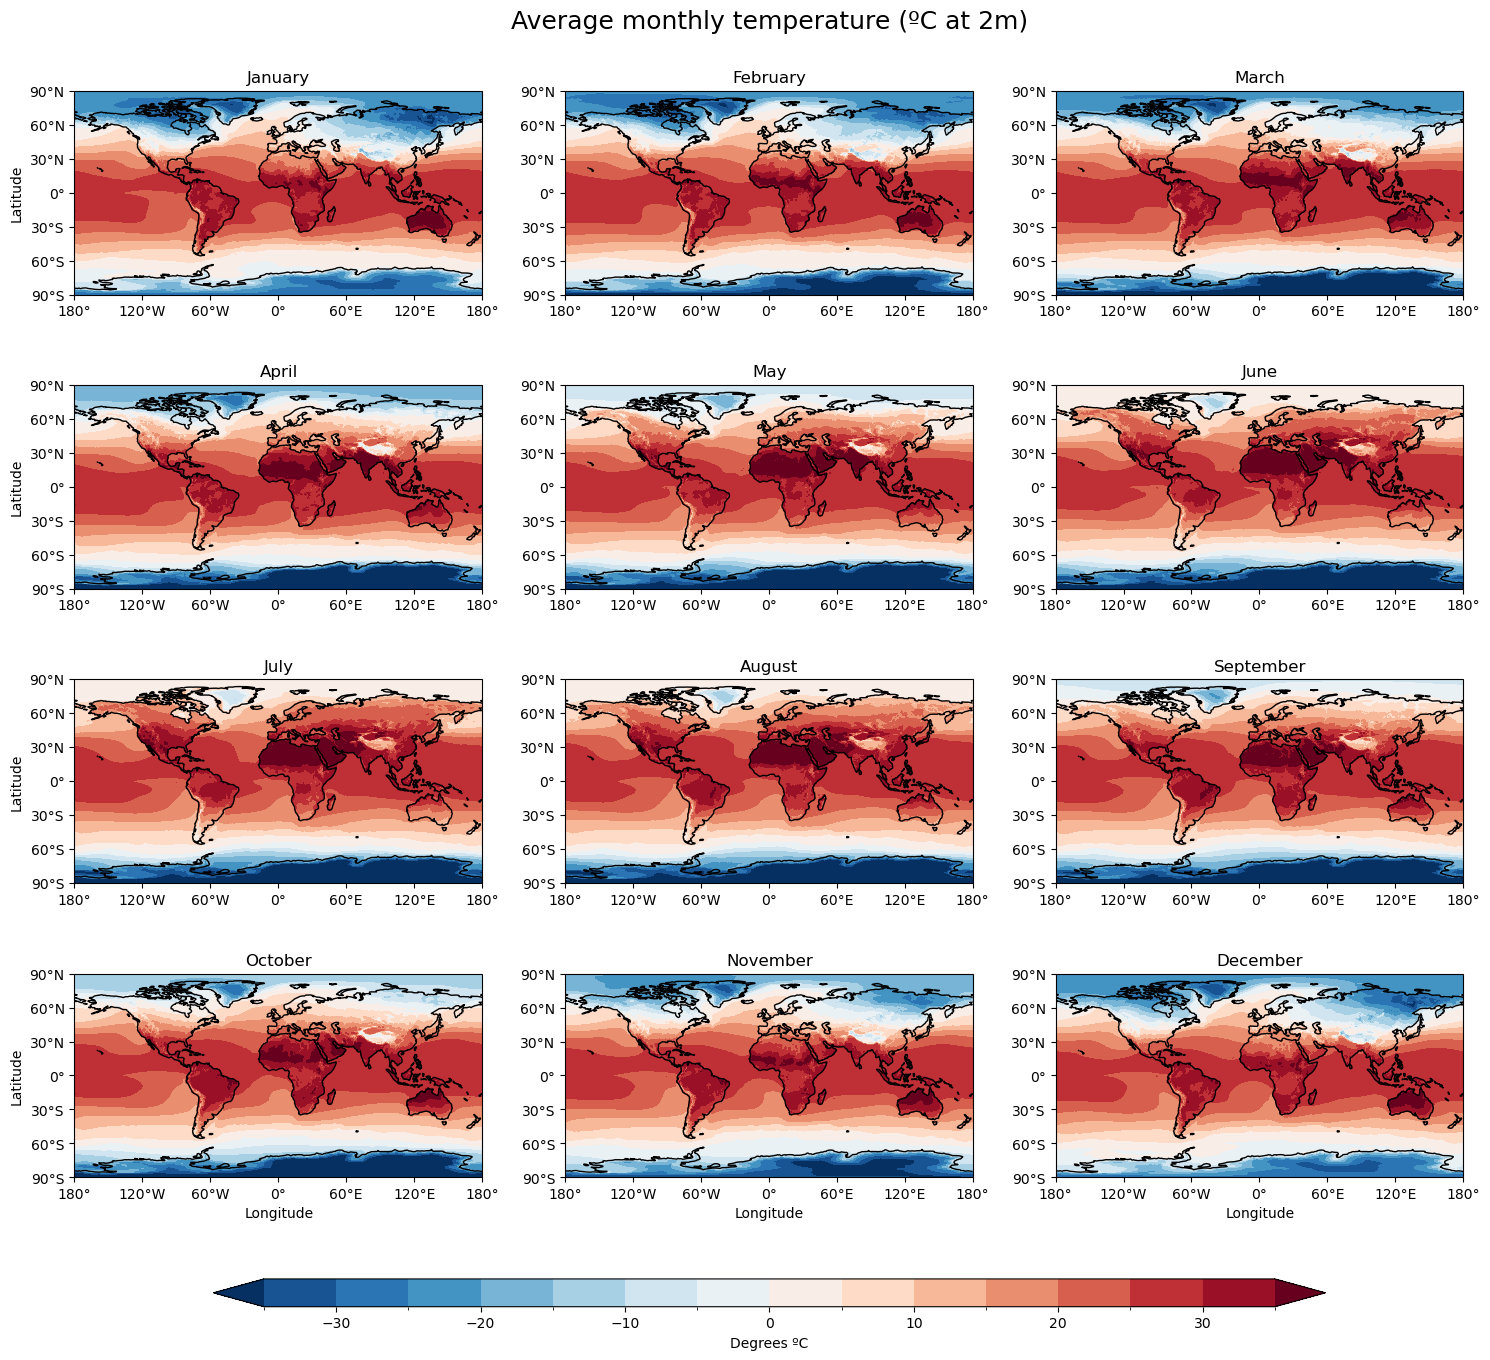

In [5]:
# Set levels for countours and colorbar
clevs = np.arange(-35, 36, 5)

# Create facet grid with one plot for each month
fg = t2m_means['t2m'].plot.contourf(
    levels=clevs,
    row='month',
    col_wrap=3,
    aspect=1.1,
    size=4,
    robust=True,
    cmap='RdBu_r',
    extend='both',
    subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={
        "location": "bottom",
        "shrink": 0.8,
        "aspect": 40,
        "label": "Degrees ºC",
    },
)

# Set labels at bottom of columns and left side of rows
fg.set_xlabels('Longitude')
fg.set_ylabels('Latitude')

for ax, month_value in zip(fg.axs.flat, t2m_means['month'].values):
    ax.coastlines()
    # Set title on each plot
    ax.set_title(calendar.month_name[month_value])
    
    # Longitude labels
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_xlim(right=181) # right-most 180º tick mark wasn't showing up without this line

    # Latitude labels
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

# Add spacing to make it look pretty
plt.subplots_adjust(wspace=0.2, bottom=0.22)
# Add and position chart title
plt.suptitle('Average monthly temperature (ºC at 2m)', fontsize=18, y=0.95)

## Composite analysis

How much does air temperature change with ENSO patterns? Here, I use the Multivariate ENSO Index ([MEI](https://psl.noaa.gov/enso/mei/)) to analyze air temperature patterns during each phase.



In [4]:
# calculate monthly anomalies 
t2m_anoms = ds.groupby('time.month') - t2m_means

In [6]:
# load in MEI data and format table
mei_data_table = pd.read_table('/home/alawyer2/mei-data/meiv2.data', header=None, skiprows=[0], 
                                sep=' ', engine='python', skipfooter=5, skipinitialspace=True, na_values='-999.00',
                                names={'year': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12})

# format table into timeseries structure before converting to xarray ds
mei_long = mei_data_table.melt(id_vars='year', var_name='months', value_name='mei')
mei_long['time'] = pd.to_datetime({'year': mei_long['year'], 'month': mei_long['months'], 'day':1})
mei_ts = mei_long.set_index('time').sort_index()['mei'].to_frame()

# match time frame to original dataset
mei_ds = mei_ts.to_xarray().sel(time=slice(t2m_anoms['time'][0], t2m_anoms['time'][-1]))

In [8]:
# define ENSO phases based on MEI (+/- 0.5 degrees)
elnino = mei_ds['mei'].where(mei_ds['mei'] >= 0.5) 
lanina = mei_ds['mei'].where(mei_ds['mei'] <= -0.5)
neutral = mei_ds['mei'].where((mei_ds['mei'] > -0.5) & (mei_ds['mei'] < 0.5)) 

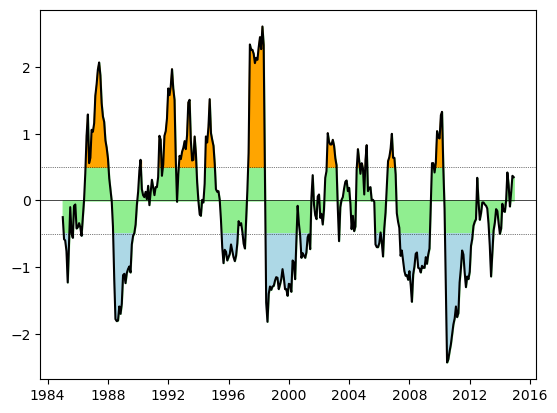

In [9]:
# plot ENSO MEI phases to see what they look like
plt.plot(mei_ds['time'], mei_ds['mei'], 'k')

plt.fill_between(mei_ds['time'].values, mei_ds['mei'], color='lightgreen')
plt.fill_between(mei_ds['time'].values, elnino, y2=0.5, color='orange')
plt.fill_between(mei_ds['time'].values, lanina, y2=-0.5, color='lightblue')

plt.axhline(0, color='black', linewidth=0.5)
plt.axhline(0.5, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(-0.5, color='black', linewidth=0.5, linestyle='dotted')

In [10]:
# find mean of t2m values conditioned on MEI phases, and compute since they're large enough to be dask arrays
elnino_t2m_means = t2m_anoms['t2m'].sel(time=elnino.dropna(dim='time')['time']).mean(dim='time').compute()
lanina_t2m_means = t2m_anoms['t2m'].sel(time=lanina.dropna(dim='time')['time']).mean(dim='time').compute()
neutral_t2m_means = t2m_anoms['t2m'].sel(time=neutral.dropna(dim='time')['time']).mean(dim='time').compute()

composite_temps = {'elnino': elnino_t2m_means, 'lanina': lanina_t2m_means, 'neutral': neutral_t2m_means}

In [11]:
# define counts to be used in plot
counts={'elnino': elnino.count(dim='time').values,
        'neutral': neutral.count(dim='time').values,
        'lanina': lanina.count(dim='time').values}

Text(0.5, 0.98, 'Composite Temperature Anomalies during ENSO Phases')

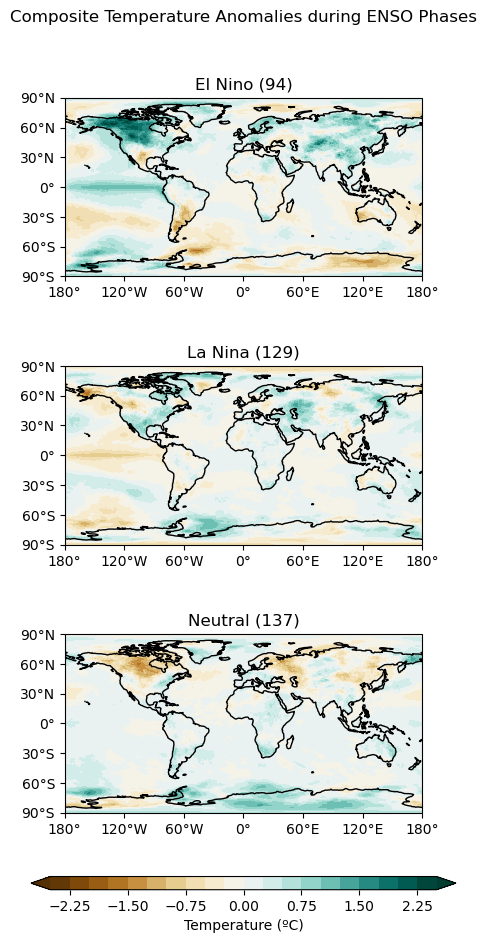

In [12]:
labels={'elnino': 'El Nino', 'lanina': 'La Nina', 'neutral': 'Neutral'}
clevs = np.arange(-2.5, 2.6, 0.25)

# Define the figure and each axis for the 3 rows and 1 column
fig, axs = plt.subplots(nrows=3, ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5, 11))

#Loop over all of the phases and plot
for i, temp in enumerate(composite_temps):
        # Select the season
        data = composite_temps[temp]

        # Add the cyclic point
        data, lons = add_cyclic_point(data, coord=composite_temps[temp]['lon'])

        # Contour plot
        cs = axs[i].contourf(lons, composite_temps[temp]['lat'], data, clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG', extend='both') 

       # Longitude labels
        axs[i].set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[temp]+' ('+str(counts[temp])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label='Temperature (ºC)')

# Add a big title at the top 
plt.suptitle('Composite Temperature Anomalies during ENSO Phases')

In [13]:
# Null Hypothesis: The difference between the means from each phase is zero
p = 0.05 # 95% confidence level, or 5% likelihood that the result arose by chance / that the null hypothesis is true

In [14]:
# compute values for each phase to use in statistical tests
elnino_temp_vals = t2m_anoms['t2m'].sel(time=elnino.dropna(dim='time')['time']).compute()
lanina_temp_vals = t2m_anoms['t2m'].sel(time=lanina.dropna(dim='time')['time']).compute()
neutral_temp_vals = t2m_anoms['t2m'].sel(time=neutral.dropna(dim='time')['time']).compute()

In [70]:
# run t-tests
tstat_el_nino, pval_el_nino = ttest_ind(elnino_temp_vals, neutral_temp_vals, equal_var = False)
tstat_la_nina, pval_la_nina = ttest_ind(lanina_temp_vals, neutral_temp_vals, equal_var = False)

In [72]:
# define masks for regions where calculated p-value is 
diff_temp = [composite_temps['elnino'] - composite_temps['neutral'], composite_temps['lanina'] - composite_temps['neutral']]

mask_diff_el_nino, mask_diff_la_nina = diff_temp[0].where(pval_el_nino <= p), diff_temp[1].where(pval_la_nina <= p)
mask_diff = [mask_diff_el_nino, mask_diff_la_nina]

Text(0.5, 0.98, 'Composite Temperature Differences for Each Phase compared to Neutral')

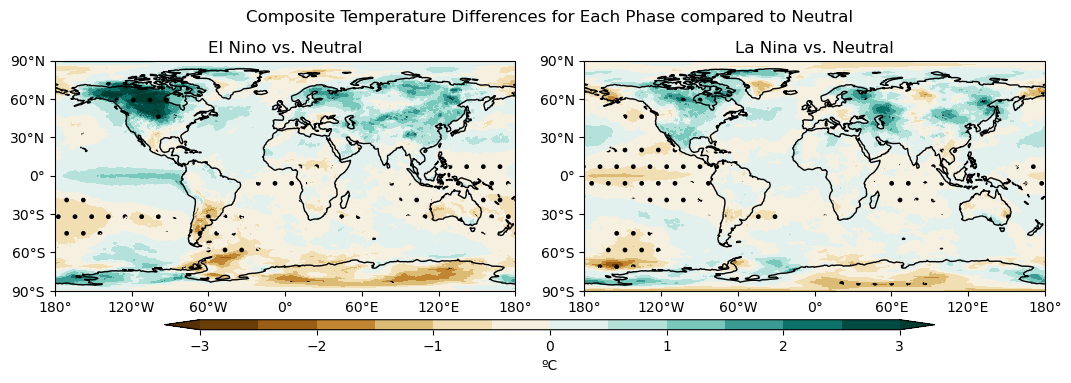

In [ ]:
labels = ['El Nino vs. Neutral', 'La Nina vs. Neutral']
clevs = np.arange(-3, 3.5, 0.5)
hatch_levs = [0]

# Define the figure and each axis for the 1 rows and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11, 4))

for i, enso in enumerate(diff_temp):

        # Select the season
        data = diff_temp[i]

        # Add the cyclic point
        data, lons = add_cyclic_point(data, coord=diff_temp[i]['lon'])
        mask_data, lons = add_cyclic_point(mask_diff[i], coord=diff_temp[i]['lon'])

        # Contour plot
        cs = axs[i].contourf(lons, diff_temp[i]['lat'], data, clevs,
                          transform=ccrs.PlateCarree(),
                          cmap='BrBG', extend='both')

        # Overlay of stippling to indicate statistical significance
        ss = axs[i].contourf(lons, diff_temp[i]['lat'], mask_data, [0, 1],
                transform = ccrs.PlateCarree(), colors=['None'],
                hatches=['.', ''], extend='both', alpha=0.0)

        # Longitude labels
        axs[i].set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, left=0.05, right=0.95,
                    wspace=0.15, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.18, 0.7, 0.025])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label='ºC')

# Add a big title at the top
plt.suptitle('Composite Temperature Differences for Each Phase compared to Neutral')

## Climate zone analysis

I used a library called [`regionmask`](https://regionmask.readthedocs.io/en/stable/index.html) to divide the data into regions defined by [IPCC AR6](https://regionmask.readthedocs.io/en/stable/defined_scientific.html#ar6-regions) (58 regions total) 

I then created a monthly mean time series plots of each region, then compared them using [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering to create 6 clusters with most similar regions (using Euclidian distance).

The goal is to map these clusters and compare them to the [Koppen Climate Zones](https://www.noaa.gov/jetstream/global/climate-zones/jetstream-max-addition-k-ppen-geiger-climate-subdivisions) to see how close we can get by only using regions grouped by air temperature data.

In [5]:
# define constants 
da_temp = ds['t2m']

# create mask of 58 regions defined from IPCC AR6 with same lat/lon points as my dataset
# https://regionmask.readthedocs.io/en/stable/defined_scientific.html#ar6-regions 
mask = regionmask.defined_regions.ar6.all.mask_3D(da_temp)

In [6]:
# compute weighted regional mean of temperatures
weights = np.cos(np.deg2rad(da_temp.lat))
ts_temps_regional = da_temp.weighted(mask * weights).mean(dim=("lat", "lon")).compute()

In [15]:
# compute yearly means per region 
ts_years = ts_temps_regional.groupby('time.year').mean(dim='time')

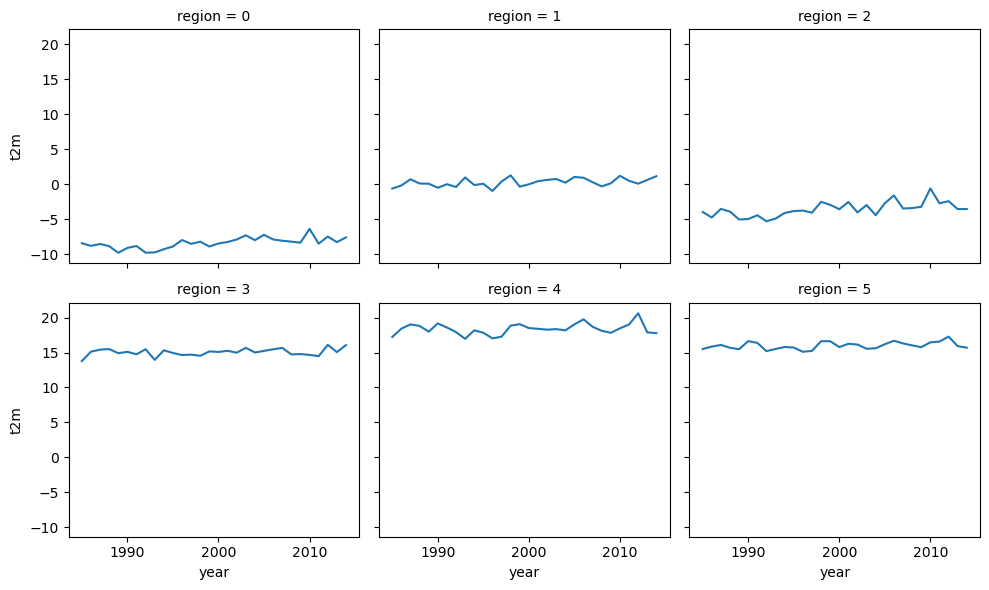

In [16]:
# plot time series of yearly means for first 6 regions 
ts_years.sel(region=slice(0, 5)).plot(col="region", col_wrap=3)

In [17]:
# compute monthly means per region 
ts_months = ts_temps_regional.groupby('time.month').mean(dim='time')

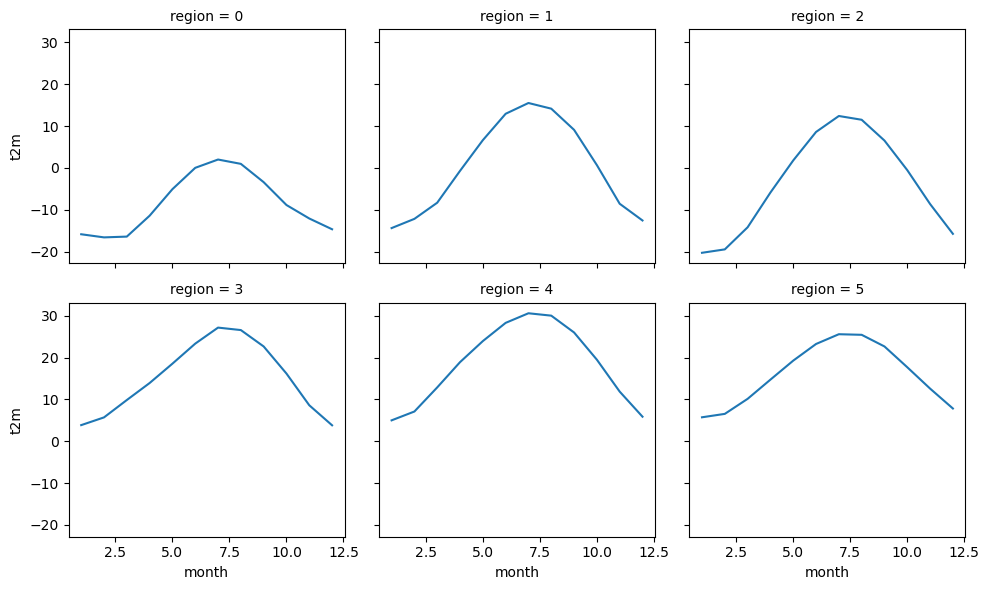

In [18]:
# plot time series of monthly means for first 6 regions 
ts_months.sel(region=slice(0, 5)).plot(col="region", col_wrap=3)

In [19]:
# convert values to numpy array
ts_arr = ts_months.transpose('region', 'month').values

In [20]:
from sklearn.cluster import KMeans

# create 6 clusters of most similar regions based on 12-month mean by region
n_clusters = 6 

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(ts_arr)

In [40]:
# add cluster labels to monthly mean DA
ts_months = ts_months.assign_coords(cluster=("region", labels))

In [ ]:
df = pd.DataFrame({
    "region": ts_months.coords["region"].values,
    "cluster": ts_months.coords["cluster"].values
})

# TODO: Expand this function to define common color per cluster and add to mask/DA to more easily map the clusters
def printClusters(dataframe):
    for cid, group in dataframe.groupby("cluster"):
        print(f"Cluster {cid}:")
        print(group["region"].tolist())
        print()

printClusters(df)

# regions_data = regionmask.defined_regions.ar6.all.mask_3D

Cluster 0:
[1, 16, 18, 29, 30, 31, 34, 57]

Cluster 1:
[6, 7, 8, 9, 10, 11, 12, 14, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41, 48, 51, 53, 54, 55]

Cluster 2:
[44, 45]

Cluster 3:
[3, 4, 5, 17, 19, 32, 33, 35]

Cluster 4:
[13, 15, 42, 43, 47, 49, 50, 52, 56]

Cluster 5:
[0, 2, 28, 46]



Text(0.5, 1.0, 'IPCC AR6 Regions Map')

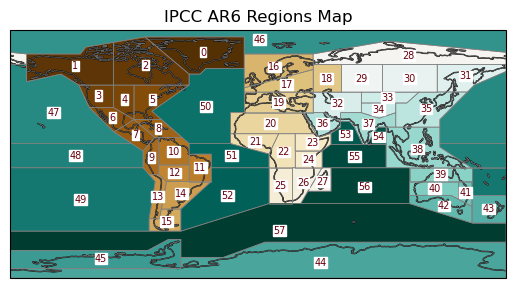

In [37]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()

text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))

regionmask.defined_regions.ar6.all.plot(
    ax=ax, text_kws=text_kws, line_kws=dict(lw=0.5, color="0.5")
)

regionmask.plot_3D_mask(mask, add_colorbar=False, cmap="BrBG")
plt.title('IPCC AR6 Regions Map')